In [1]:
# 使用models模块创建并训练神经网络模型
import pandas as pd
import scutquant.scutquant as q
from scutquant import alpha, report, executor

In [2]:
df = pd.read_csv("D:/Desktop/data.csv")
df["datetime"] = pd.to_datetime(df["datetime"])
df["mean_price"] = df["amount"] / df["vol"] * 10  # 每支股票在当天的交易均价
df.set_index(["datetime", "ts_code"], inplace=True)
df.index.names = ["datetime", "instrument"]
df

open    high     low   close  pre_close  change  \
datetime   instrument                                                      
2006-01-04 000001.SZ     6.13    6.33    6.12    6.28       6.14    0.14   
           000002.SZ     4.40    4.67    4.40    4.66       4.31    0.35   
           000012.SZ     4.70    4.75    4.55    4.70       4.62    0.08   
           000016.SZ     3.52    3.58    3.52    3.57       3.52    0.05   
           000021.SZ     7.99    8.40    7.99    8.32       8.00    0.32   
...                       ...     ...     ...     ...        ...     ...   
2022-12-30 688363.SH   136.00  137.00  131.50  135.28     135.49   -0.21   
           688396.SH    53.06   53.40   52.49   52.65      52.87   -0.22   
           688561.SH    65.49   67.88   64.85   65.77      65.46    0.31   
           688599.SH    63.31   64.56   62.31   63.76      63.20    0.56   
           688981.SH    41.01   41.35   41.01   41.14      40.89    0.25   

                       pct_chg        vol       amount  mean_price  
datetime   instrument                                               
2006-01-04 000001.SZ    2.2800  154450.68   96989.0066    6.279610  
           000002.SZ    8.1200  389310.43  175187.0657    4.499933  
           000012.SZ    1.7300   40399.61   18863.8625    4.669318  
           000016.SZ    1.4200   14426.65    5131.8793    3.557222  
           000021.SZ    4.0000   33526.60   27657.1708    8.249322  
...                        ...        ...          ...         ...  
2022-12-30 688363.SH   -0.1550   29951.60  401624.1560  134.091052  
           688396.SH   -0.4161   23401.54  123568.2880   52.803486  
           688561.SH    0.4736   22567.89  149379.0770   66.190981  
           688599.SH    0.8861  109144.36  695759.9350   63.746760  
           688981.SH    0.6114   60396.11  248594.8820   41.160744  

[1199445 rows x 10 columns]

In [3]:
# 构造目标值, 并按照-10% 和10%截断(因为有涨跌停限制)
df["label"] = df["pct_chg"].groupby("instrument").shift(-2)
df = df.dropna()
df["label"].describe()

count    1.197673e+06
mean     5.759776e-02
std      2.858067e+00
min     -4.650000e+01
25%     -1.330000e+00
50%      0.000000e+00
75%      1.370000e+00
max      1.249400e+02
Name: label, dtype: float64

In [4]:
kwargs = {
    "data": df,
    "open": "open",
    "close": "close",
    "high": "high",
    "low": "low",
    "volume": "vol",
    "amount": "amount",
}
X = alpha.make_factors(kwargs=kwargs)
X = pd.concat([X, df[["label"]]], axis=1)
X = X.dropna()
X

time used: 139.44174885749817


CLOSE5   ROC5     BETA5       MA5      STD5  \
datetime   instrument                                                  
2006-04-07 000001.SZ   0.984544 -0.180  0.003091  1.006801  0.011801   
           000002.SZ   0.959004 -0.144  0.008199  1.009370  0.011831   
           000059.SZ   0.925408 -0.136  0.014918  0.968765  0.018250   
           000061.SZ   0.804309  0.018  0.039138  0.899820  0.078477   
           000063.SZ   0.972999 -0.030  0.005400  1.012706  0.017316   
...                         ...    ...       ...       ...       ...   
2022-12-28 688363.SH   0.913302  2.158  0.017340  0.977189  0.028128   
           688396.SH   1.014528 -0.354 -0.002906  1.003208  0.009834   
           688561.SH   0.938309  0.610  0.012338  1.005057  0.033432   
           688599.SH   0.855389  1.614  0.028922  0.930134  0.057758   
           688981.SH   1.009535 -0.278 -0.001907  1.007042  0.006198   

                           MAX5      MIN5     QTLU5     QTLD5   CLOSE10  ...  \
datetime   instrument                                                    ...   
2006-04-07 000001.SZ   1.020093  0.990726  1.016383  0.998145  0.975270  ...   
           000002.SZ   1.021962  0.995608  1.020791  0.999122  0.868228  ...   
           000059.SZ   1.000000  0.955711  0.975758  0.957576  0.955711  ...   
           000061.SZ   1.000000  0.829443  0.971275  0.829443  0.773788  ...   
           000063.SZ   1.040343  0.996188  1.018996  0.999238  0.930432  ...   
...                         ...       ...       ...       ...       ...  ...   
2022-12-28 688363.SH   1.014707  0.954703  1.002941  0.955350  0.950805  ...   
           688396.SH   1.013962  0.990377  1.012604  0.997623  1.074906  ...   
           688561.SH   1.031379  0.948972  1.024676  0.989794  0.992993  ...   
           688599.SH   1.000000  0.859216  0.969260  0.878603  0.871492  ...   
           688981.SH   1.014181  1.000000  1.013203  1.003130  1.040831  ...   

                         CORD10    CORD20    CORD30    CORD60   AMOUNT5  \
datetime   instrument                                                     
2006-04-07 000001.SZ   0.155513  0.128514  0.119499  0.095652  0.847906   
           000002.SZ   0.190658  0.176532  0.167634  0.127716  0.846304   
           000059.SZ   0.418714  0.461792  0.491000  0.457381  0.334477   
           000061.SZ   0.149534  0.169854  0.115921  0.103415  0.201339   
           000063.SZ   0.096691  0.094505  0.072558  0.051835  0.433476   
...                         ...       ...       ...       ...       ...   
2022-12-28 688363.SH   0.078046  0.137349  0.070837  0.094732  0.391778   
           688396.SH   0.354356  0.363389  0.427889  0.239899  1.674625   
           688561.SH   0.147839  0.110531  0.084391 -0.021513  0.494056   
           688599.SH  -0.030659  0.029691  0.137351 -0.162064  0.528563   
           688981.SH   0.275861  0.252323  0.242731  0.186383  1.126837   

                       AMOUNT10  AMOUNT20  AMOUNT30  AMOUNT60   label  
datetime   instrument                                                  
2006-04-07 000001.SZ   0.586163  0.845426  2.391277  1.251323  2.6700  
           000002.SZ   0.604176  0.228810  0.560573  0.493426  2.5300  
           000059.SZ   2.274942  0.478818  0.650543  0.194657 -2.0700  
           000061.SZ   0.097644  0.105429  0.429122  0.471194 -0.1800  
           000063.SZ   0.575827  0.158053  0.329017  0.588615 -0.7900  
...                         ...       ...       ...       ...     ...  
2022-12-28 688363.SH   0.947322  0.719363  1.316014  0.427300 -0.1550  
           688396.SH   4.719745  1.218943  2.626182  1.643164 -0.4161  
           688561.SH   1.735394  1.894400  1.826660  1.045160  0.4736  
           688599.SH   0.575414  0.813492  0.810529  0.576380  0.8861  
           688981.SH   5.155468  1.256573  3.713760  0.867828  0.6114  

[1141117 rows x 152 columns]

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1141117 entries, (Timestamp('2006-04-07 00:00:00'), '000001.SZ') to (Timestamp('2022-12-28 00:00:00'), '688981.SH')
Columns: 152 entries, CLOSE5 to label
dtypes: float64(152)
memory usage: 1.3+ GB
None
X_mis= 0.0
clean dataset done 

split data done 

label norm done 

The distribution of y_train:


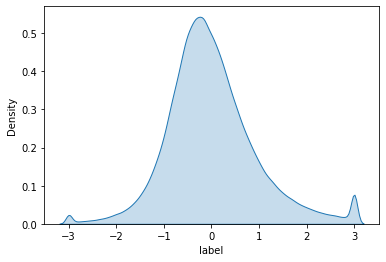

The distribution of y_valid:


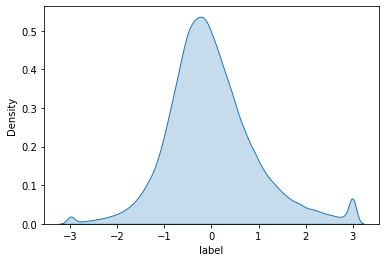

The distribution of y_test:


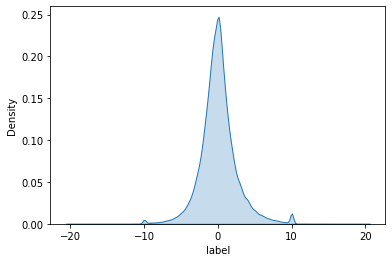

norm data done 

all works done 



In [5]:
split_params = {
    "test_date": "2019-01-01",
    "split_method": "split",
    "split_kwargs":{
        "train": 0.7,
        "valid": 0.3
    }
}

# 从训练集中按7：3的比例随机拆分出验证集, 并在截面上进行标准化
result = q.auto_process(X, "label", groupby="instrument", split_params=split_params, select=False, orth=False)

X_train, y_train, X_valid, y_valid = result["X_train"], result["y_train"], result["X_valid"], result["y_valid"]
X_test, y_test, ymean, ystd = result["X_test"], result["y_test"], result["ymean"], result["ystd"]

In [7]:
from scutquant import models

attention = models.Attention(epochs=30)
attention.fit(X_train, y_train, X_valid, y_valid)

pred = attention.predict(X_test)
pred = pd.DataFrame(pred, columns=["predict"], index=X_test.index)
pred["predict"] += ymean.groupby("datetime").shift(2).fillna(0.0002)
pred["predict"] *= ystd.groupby("datetime").shift(2).fillna(0.0189)

pred.describe()

Epoch 1/30
2353/2353 [==============================] - 140s 60ms/step - loss: 1.0673 - mae: 0.7318 - mape: 1452.0557 - val_loss: 1.0108 - val_mae: 0.7200 - val_mape: 3088.8564
Epoch 2/30
2353/2353 [==============================] - 137s 58ms/step - loss: 0.9794 - mae: 0.7068 - mape: 1837.6943 - val_loss: 0.9618 - val_mae: 0.7108 - val_mape: 1265.7430
Epoch 3/30
2353/2353 [==============================] - 137s 58ms/step - loss: 0.9297 - mae: 0.7038 - mape: 781.2769 - val_loss: 0.9188 - val_mae: 0.7105 - val_mape: 1107.2085
Epoch 4/30
2353/2353 [==============================] - 138s 59ms/step - loss: 0.8980 - mae: 0.7032 - mape: 633.5670 - val_loss: 0.9004 - val_mae: 0.7053 - val_mape: 783.7449
Epoch 5/30
2353/2353 [==============================] - 138s 59ms/step - loss: 0.8912 - mae: 0.7031 - mape: 734.5711 - val_loss: 0.8992 - val_mae: 0.7071 - val_mape: 909.4425
Epoch 6/30
2353/2353 [==============================] - 137s 58ms/step - loss: 0.8923 - mae: 0.7031 - mape: 683.7041 - v

,predict
count,280721.000000
mean,0.000047
std,0.001835
min,-0.012287
25%,-0.000973
50%,0.000063
75%,0.001054
max,0.017542


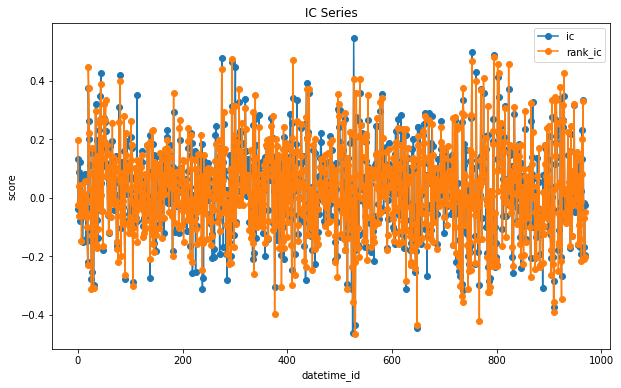

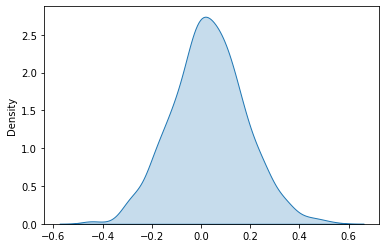

ic= 0.030185674997222394 icir= 0.20151237322966523 rank_ic= 0.02740021487137522 rank_icir= 0.17591885393381


0.024242824881609087

In [8]:
# 使用IC评判拟合优度
ic, icir, rank_ic, rank_icir = q.ic_ana(pred, y_test, groupby='datetime')
print('ic=', ic, 'icir=', icir, 'rank_ic=', rank_ic, 'rank_icir=', rank_icir)
# 使用pearson相关系数评判拟合优度
r = q.pearson_corr(pred.values, y_test)
r[0]

In [9]:
model = attention.model
# print(model.summary())
model.save("attention")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: attention\assets
